# The Problem

In this notebook, we implement a DQN agent to navigate a square world and collect yellow banas as reward.  

**state**: conitunous, size=37  
**action**: discrete, size=4  
**reward**: +1 for yellow bananas, -1 for blue bananas  
**task**: episodic, and is considered as solved, when the mean score over 100 episodes reaches 13

When interacting with the environment, the agent
- observe the current state $S_t$, 
- make an action $A_t$, 
- collection the reward $R_{t+1}$, 
- observe the next state $S_{t+1}$ and get a boolean `done` indicating whether it is the end of the episode. 

From the experience, the agent should learn a good approximation of the action value function $Q(S_t; A_t)$. 


# The Solution

## Neural Network  

In this implementation, we use a neural network with two hidden layers, to estimate the action values for a state.

```
nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size))

```

## Loss Function

Naturally, we would want to minimize the MSE, 

$J(\theta) = [ Q(S_t, A_t) - \hat{Q}(S_t, A_t, \theta) ]^2$,

by updating the weights with the negative gradient of the loss function,

$\theta \to \theta - \alpha \nabla_{\theta} J(\theta)$


But the true action value function $Q(S_t; A_t)$ is unknown, so we will use **TD-error** instead, where the true action value function is replaced with the **fixed Q-target**,  

$J(\theta) = [ (R_{t+1} + \gamma * \max_{a}\hat{Q}_{target}(S_{t+1}, a; \theta')) * (1- \text{done}) - \hat{Q}(S_t, A_t; \theta) ]^2$ 

- The weight $\theta'$ is mantained in a separate "target" neural network (of the same architecture as the "predictor" network)
- We feed a batch of $(S_t, A_t, R_{t+1}, S_{t+1}, \text{done})$ through the two networks. Calculate the TD-error, and update the weight of the predictor network, $\theta$ accordingly.
- Note that the operation on the target network should be in `.detach()` mode, since we don't need gradient from it. The weight of the target network, $\theta'$ is soft updated with the weight of the predictor network, $\theta$, every few steps: $\theta' \to (1-\tau)\theta'+\theta$  


## Replay Buffer

The current and next state are highly correlated. With online learning, we could be reinforcing over a not so ideal actions or get stuck in a state. 

To stablize training, we separate out learning and playing. 

While playing, the agent stores the experience in a buffer (a `deque`, that holds the most recent `n` experience tuples). After a few playing steps, the agent performs one learning step by sampling a small batch of experience tuples uniformly, feed them through the neural networks, and then update the weight of the predictor and the target network. 

## Agent

As described above, the agent has two functions

- to play
    - sample an action using epsilon-greedy with decay after each episode
    - save the playing experience in the replay buffer
- and to learn
    - sample the past experiences in the replay buffer
    - update the neural networks weights to minimize TD-error

## Psuedo-code

Let's combine every pieces together:


```
for each episode:

    reset the environment and observe starting state S_t
    decay the epsilon -> max(epsilon * epsilon_decay, min_epsilon)
    
    while the episode has not end:
    
        - agent samples an action using Q(S_t, a \in A(S_t)) epsilon-greedily
        - env steps on the chosen action, and returns next_state, reward, done
        - agent saves (state, action, next_state, reward, done) tuple to buffer

        every other x time step:
        
            - agent sampels a batch of experience tuple
            - agent feeds the experience to NNs, calculate the loss, update the weights
                
```


# The Implementation

I implemented the following 2 agents:  
- vanilla DQN in `dqn_agent.py`
- **Double DQN** with **Prioritized Experience Replay** with **Dueling Network** in `improved_dqn_agent.py`. It includes the following changes: 
    - in the target network, $max_a\hat{Q}_{\text{target}}(S_{t+1}, a \in A(S_{t+1}) ; \theta')$ is replaced with $\hat{Q}_{\text{target}}(S_{t+1}, \arg\max_a\hat{Q}_{\text{pred}}(S_{t+1}, a \in A(S_{t+1}); \theta), \theta')$. This reduced over-estimation of Q-values early on.  
    - add probability to the experience buffer $E$. A new experience $i$'s probability will be initialized at $p_i=\max p_j$ $ \forall j \in E$ or $p_i=1$ when the buffer is empty. The sampling probability of experience $i$ is $\frac{p_i^\alpha}{\sum_{j}p_j^\alpha}$. Here, $\alpha$ controls how much we'd like to prioiritize; when $\alpha=0$, it is the same as uniform sampling. The importance sampling weight is calculated as $w_i=(\frac{1}{N}\frac{1}{p_i})^\beta/\max_j w_j$, and we also multiply the original loss function by this term. When a experience is sampled and passed through the network, we update its $p_i$ with the TD-error $|\delta_t|$
    - after the first hidden layer of the neural network, seperate out the estimation for state value and action advantages. At the end of the network, combine the output as `V(s) + Adv(s, a) - Adv(s, a).mean()`

At the bottom of this notebook, you can watch my trained agent going bananas at yellow bananas ;)

# Training the Agents

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from unityagents import UnityEnvironment
import numpy as np

In [3]:
env = UnityEnvironment(
    file_name="/Users/zinanj/projects/udacity/drlnd/deep-reinforcement-learning/p1_navigation/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
env_info = env.reset(train_mode=True)[brain_name]
print(f'numer of agents: {len(env_info.agents)}')
action_size = brain.vector_action_space_size
print(f'action space: {action_size}')

state = env_info.vector_observations[0]
state_size = len(state)
print(f'state size: {state_size}')
print(f'a sample state: {state}')

numer of agents: 1
action space: 4
state size: 37
a sample state: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]


In [6]:
from collections import deque
import torch
import pickle

In [7]:
WINDOW = 100

def run(agent, n_episodes=2000, max_t=300, max_eps=1.0, min_eps=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=WINDOW)
    eps = max_eps
    name = agent.name
    
    for i in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name] 
        state = env_info.vector_observations[0]
        score = 0
        
        for j in range(max_t):
            action = agent.sample(state, eps)
            
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]  
            
            agent.step(state, action, reward, next_state, done)
            
            score += reward   
            state = next_state 
            
            if done:
                break
        
        scores.append(score)
        scores_window.append(score)
        eps = max(eps * eps_decay, min_eps)
        print(f"\rEpisode: {i}, Average Score: {np.mean(scores_window)}", end="")
        
        if i % WINDOW == 0:
            print(f"\rEpisode: {i}, Average Score: {np.mean(scores_window)}")
        
        if np.mean(scores_window) >= 13:
            print(f"\rEnvironment solved in {i} episodes, Average Score {np.mean(scores_window)}")
            torch.save(agent.q_pred_network.state_dict(), f'{name}_checkpoint.pth')
            break
    
    with open(f'{name}_scores.pkl', 'wb') as f:
        pickle.dump(scores, f)
            
    return scores

In [24]:
from dqn_agent import DQNAgent

dqn_agent = DQNAgent(state_size, action_size)
dqn_scores = run(dqn_agent)

Episode: 100, Average Score: 1.05204081632653352
Episode: 200, Average Score: 3.79
Episode: 300, Average Score: 7.19
Episode: 400, Average Score: 10.09
Environment solved in 478 episodes, Average Score 13.03


In [97]:
from improved_dqn_agent import DoubleDQNAgent

ddqn_agent = DoubleDQNAgent(state_size, action_size)
ddqn_scores = run(ddqn_agent)

Episode: 100, Average Score: 0.632626262626263352
Episode: 200, Average Score: 4.26
Episode: 300, Average Score: 7.92
Episode: 400, Average Score: 10.13
Episode: 500, Average Score: 11.83
Environment solved in 532 episodes, Average Score 13.0


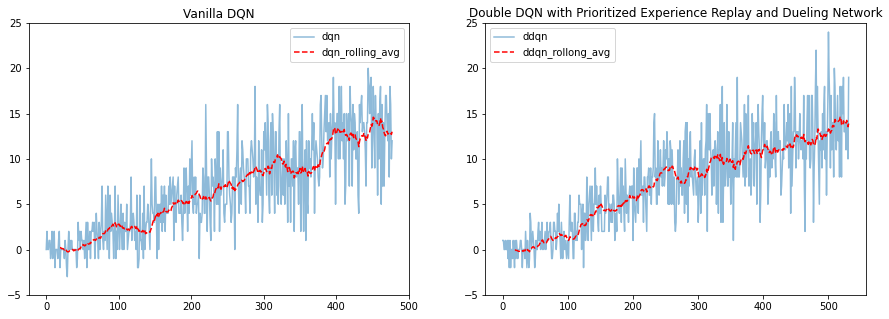

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# import pickle
# dqn_scores = pickle.load(open("./DQNAgent_scores.pkl", "rb" ))
# ddqn_scores = pickle.load(
#     open("DoubleDQNAgentWithPrioritizedReplay_scores.pkl", "rb" ))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(dqn_scores, label='dqn', alpha=0.5)
ax[0].plot(pd.DataFrame(dqn_scores).rolling(20).mean(), color='r', linestyle='--', label='dqn_rolling_avg');
ax[0].set_title('Vanilla DQN')
ax[0].legend();
ax[0].set_ylim(-5, 25); ax[1].set_ylim(-5, 25)
ax[1].plot(ddqn_scores, label='ddqn', alpha=0.5)
ax[1].plot(pd.DataFrame(ddqn_scores).rolling(20).mean(), 
        color='r', linestyle='--', label='ddqn_rollong_avg');
ax[1].set_title('Double DQN with Prioritized Experience Replay and Dueling Network')
plt.legend()

# Evaluation 


Next we are going to load the saved trained weights and see how does the agent perform

In [36]:
from dqn_agent import DQNAgent

dqn_agent = DQNAgent(state_size, action_size)
dqn_agent.q_pred_network.load_state_dict(
    torch.load('DQNAgent_checkpoint.pth'))

In [37]:
from improved_dqn_agent import DoubleDQNAgent

ddqn_agent = DoubleDQNAgent(state_size, action_size)
ddqn_agent.q_pred_network.load_state_dict(
    torch.load('DoubleDQNAgentWithPrioritizedReplay_checkpoint.pth'))

In [39]:
def test_agent(agent, num_episodes=100):
    scores = []
    for i in range(num_episodes):
        env_info = env.reset(train_mode=True)[brain_name] 
        state = env_info.vector_observations[0]            
        score = 0                                          
        while True:
            action = agent.sample(state, 0)        
            env_info = env.step(action)[brain_name]        
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]                  
            score += reward                                
            state = next_state                             
            if done:                                       
                break
        scores.append(score)
    return scores

In [40]:
dqn_test_scores = test_agent(dqn_agent)
ddqn_test_score = test_agent(ddqn_agent)

In [107]:
dqn_test_scores_df = pd.DataFrame(dqn_test_scores, columns=['score'])
ddqn_test_scores_df = pd.DataFrame(ddqn_test_score, columns=['score'])

dqn_test_scores_df.to_csv('./dqn_test_scores_df.csv', index=False)
ddqn_test_scores_df.to_csv('./ddqn_test_scores_df.csv', index=False)

dqn_test_scores_df = pd.read_csv('./dqn_test_scores_df.csv')
ddqn_test_scores_df = pd.read_csv('./ddqn_test_scores_df.csv')

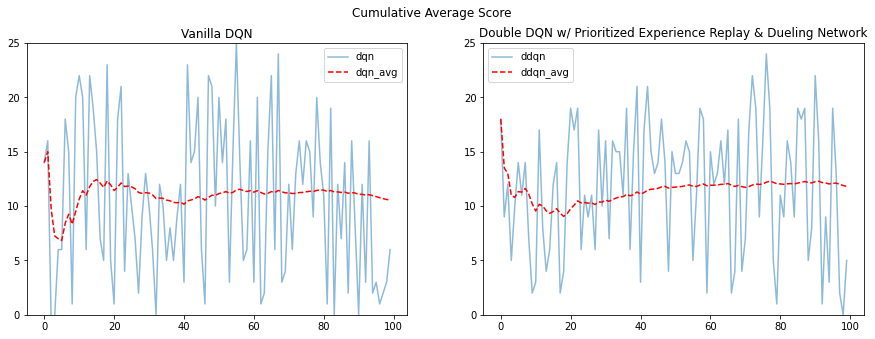

In [114]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(dqn_test_scores, label='dqn', alpha=0.5)
ax[0].plot(
    dqn_test_scores_df.cumsum()['score'] / (pd.Series(dqn_test_scores_df.index)+1), 
    color='r', linestyle='--', label='dqn_avg');
ax[0].set_title('Vanilla DQN')
ax[0].legend();
ax[0].set_ylim(0, 25); ax[1].set_ylim(0, 25)
ax[1].plot(ddqn_test_score, label='ddqn', alpha=0.5)
ax[1].plot(
    ddqn_test_scores_df.cumsum()['score'] / (pd.Series(ddqn_test_scores_df.index)+1), 
    color='r', linestyle='--', label='ddqn_avg');
ax[1].set_title('Double DQN w/ Prioritized Experience Replay & Dueling Network')
plt.legend();
plt.suptitle('Cumulative Average Score');
plt.show()

In [109]:
print(
    f"The average test score over 100 episodes for vanilla DQN is: {dqn_test_scores_df.mean().score}")
print(
    f"The average test score over 100 episodes for improved DQN is: {ddqn_test_scores_df.mean().score}")

The average test score over 100 episodes for vanilla DQN is: 10.56
The average test score over 100 episodes for improved DQN is: 11.82


Not bad! You can see the agent in action in the youtube video below

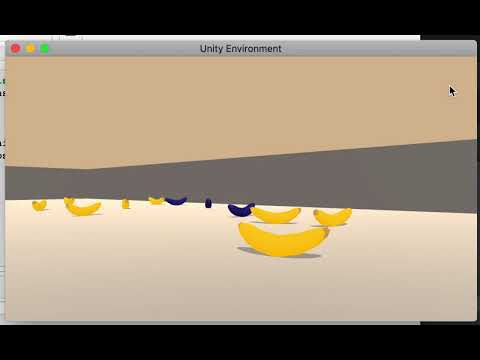

In [104]:
# https://youtu.be/IPRzAoFQXUc
from IPython.display import YouTubeVideo
YouTubeVideo('IPRzAoFQXUc')

# Improvements

I noticed that when the agent's visual field is filled with blue bananas, it would shift quickly between the turn left and turn right actions, and ends up being stuck in one spot. The agent needs to learn how to break the fixation of state. Collecting a few blue banana in exchange for a different state is much better than getting stuck and collectiong nothing!

The performance of the improved agent (Double DQN, Prioritized Experience Replay and Dueling Network) is not significantly better than vanilla DQN. It also takes longer to train due to re-evaluation of sampling probability at every learning step. I am underwhelmed by the result and would like to investigate more.